In [81]:
import os
import sys

sys.path.append("../python")

import matplotlib.pyplot as plt
import numpy as np

In [82]:
from data import Dataloader
import metrics

In [83]:
# Loading the data
data_loader = Dataloader("../data/dataset_10") # Specify path to the dataset you want to load
X, Y= data_loader.load()


In [84]:
df= X-Y
Z=np.load("../data/dataset_10/Z.npy")

In [85]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Assuming you have your data as 'data' and ground truth labels as 'ground_truth_labels'

# Create KMeans instance for 3 clusters
kmeans = KMeans(n_clusters=3)

# Fit the model
kmeans.fit(df)

# Predict the clusters
predicted_labels = kmeans.labels_

# Evaluate the performance
score = adjusted_rand_score(Z, predicted_labels)
print("Adjusted Rand Index:", score)


Adjusted Rand Index: 0.4097574644119175


In [86]:
# from sklearn.cluster import SpectralClustering
# from sklearn.metrics import adjusted_rand_score

# # Assuming your data is in 'data' and ground truth labels in 'ground_truth_labels'

# # Create SpectralClustering instance
# spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors')

# # Fit the model
# spectral.fit(df)

# # Predict the clusters
# predicted_labels = spectral.labels_

# # Evaluate the performance
# score = adjusted_rand_score(Z, predicted_labels)
# print("Adjusted Rand Index:", score)

In [87]:
print(X[0])

[0.13155  0.102793 0.266773 0.273273 0.482818 0.598529 0.443253 0.079392
 0.696425 0.205184]


In [88]:
import numpy as np

def split_dataset(X, split_table):
    dataset_0 = []
    dataset_1 = []
    dataset_2 = []

    for i in range(len(split_table)):
        if split_table[i]==0:
            dataset_0.append(X[i])
        if split_table[i]==1:
            dataset_1.append(X[i])
        if split_table[i]==2:
            dataset_2.append(X[i])

    # Return the datasets as tuples
    return np.array(dataset_0),np.array(dataset_1), np.array(dataset_2)

# Example usage
X_0, X_1, X_2 = split_dataset(X, predicted_labels)

Y_0, Y_1, Y_2 = split_dataset(Y, predicted_labels)

# X_0 = list(list(array) for array in X_0)
# X_1 = list(list(array) for array in X_1)
# X_2 = list(list(array) for array in X_2)
# Y_0 = list(list(array) for array in Y_0)
# Y_1 = list(list(array) for array in Y_1)
# Y_2 = list(list(array) for array in Y_2)



In [89]:
print(predicted_labels)

[1 2 0 ... 1 1 1]


In [90]:
import numpy as np

import keras
from keras import backend
from keras.layers import Activation, Add, Dense, Input, Lambda, Dropout, Subtract
from keras.models import Model, Sequential
from keras.utils import plot_model
%pylab inline

INPUT_DIM = 10

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [91]:
def create_base_network(input_dim):
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Dense(INPUT_DIM, input_shape=(input_dim,), activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(64, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(32, activation='relu'))
    seq.add(Dense(1))
    return seq

In [92]:
def create_meta_network(input_dim, base_network):
    input_a = Input(shape=(input_dim,))
    input_b = Input(shape=(input_dim,))

    rel_score = base_network(input_a)
    irr_score = base_network(input_b)

    # subtract scores
    diff = Subtract()([rel_score, irr_score])

    # Pass difference through sigmoid function.
    prob = Activation("sigmoid")(diff)

    # Build model.
    model = Model(inputs = [input_a, input_b], outputs = prob)
    model.compile(optimizer = "adam", loss = "binary_crossentropy")

    return model

In [93]:
base_network_1 = create_base_network(INPUT_DIM)
model_1 = create_meta_network(INPUT_DIM, base_network_1)
model_1.summary()

base_network_2 = create_base_network(INPUT_DIM)
model_2 = create_meta_network(INPUT_DIM, base_network_2)
model_2.summary()

base_network_3 = create_base_network(INPUT_DIM)
model_3 = create_meta_network(INPUT_DIM, base_network_3)
model_3.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 sequential_15 (Sequential)     (None, 1)            2927        ['input_31[0][0]',               
                                                                  'input_32[0][0]']               
                                                                                                  
 subtract_15 (Subtract)         (None, 1)            0           ['sequential_15[0][0]',   

In [94]:
y_0 = np.ones((len(X_0), 1))
y_1 = np.ones((len(X_1), 1))
y_2 = np.ones((len(X_2), 1))

In [95]:
print(X_0)
print(Y_0)
print(y_0)

[[0.063892 0.911273 0.806567 ... 0.768162 0.062565 0.7225  ]
 [0.734527 0.932119 0.946412 ... 0.615256 0.524477 0.334976]
 [0.618549 0.19205  0.200985 ... 0.742065 0.833518 0.413484]
 ...
 [0.503326 0.26748  0.099818 ... 0.694553 0.606376 0.95908 ]
 [0.61064  0.901132 0.162891 ... 0.972982 0.57055  0.809237]
 [0.486078 0.312517 0.91313  ... 0.390122 0.384981 0.983046]]
[[0.98267  0.991958 0.785311 ... 0.852587 0.94458  0.06482 ]
 [0.977782 0.021238 0.771218 ... 0.219349 0.464368 0.056511]
 [0.757219 0.728129 0.282502 ... 0.526059 0.419308 0.728467]
 ...
 [0.218459 0.028237 0.843273 ... 0.281553 0.079757 0.913161]
 [0.824696 0.248319 0.016792 ... 0.401544 0.855044 0.58998 ]
 [0.433534 0.42741  0.980633 ... 0.927235 0.770221 0.527018]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [98]:
# Train model.

es=keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=1, mode='auto')

NUM_EPOCHS = 20
BATCH_SIZE = 10
history_1 = model_1.fit([X_0, Y_0], y_0,  
                    batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, verbose = 1)

Epoch 1/20
   1/1306 [..............................] - ETA: 6s - loss: 2.4438e-07

1306/1306 [==============================] - 2s 1ms/step - loss: 0.0038
Epoch 2/20
1306/1306 [==============================] - 2s 2ms/step - loss: 0.0047
Epoch 3/20
1306/1306 [==============================] - 2s 2ms/step - loss: 0.0047
Epoch 4/20
1306/1306 [==============================] - 2s 2ms/step - loss: 0.0054
Epoch 5/20
1306/1306 [==============================] - 3s 2ms/step - loss: 0.0033
Epoch 6/20
1306/1306 [==============================] - 3s 2ms/step - loss: 0.0036
Epoch 7/20
1306/1306 [==============================] - 2s 2ms/step - loss: 0.0043
Epoch 8/20
1306/1306 [==============================] - 3s 2ms/step - loss: 0.0032
Epoch 9/20
1306/1306 [==============================] - 2s 2ms/step - loss: 0.0044
Epoch 10/20
1306/1306 [==============================] - 2s 2ms/step - loss: 0.0027
Epoch 11/20
1306/1306 [==============================] - 2s 2ms/step - loss: 0.0018
Epoch 12/20
1306/1306 [==============================] - 2s 2ms/step - loss: 0.0033
Epoch 13/20


KeyError: 'val_loss'

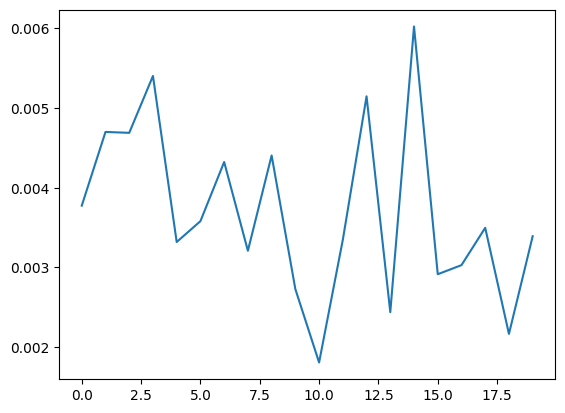

In [99]:
# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [100]:
history_2 = model_2.fit([X_1, Y_1], y_1,  
                    batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, verbose = 1)
history_3 = model_3.fit([X_2, Y_2], y_2,  
                    batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, verbose = 1)

Epoch 1/20
1396/1396 [==============================] - 2s 1ms/step - loss: 0.1319
Epoch 2/20
1396/1396 [==============================] - 2s 1ms/step - loss: 0.0353
Epoch 3/20
1396/1396 [==============================] - 2s 1ms/step - loss: 0.0248
Epoch 4/20
1396/1396 [==============================] - 2s 1ms/step - loss: 0.0156
Epoch 5/20
1396/1396 [==============================] - 2s 1ms/step - loss: 0.0130
Epoch 6/20
1396/1396 [==============================] - 3s 2ms/step - loss: 0.0140
Epoch 7/20
1396/1396 [==============================] - 3s 2ms/step - loss: 0.0105
Epoch 8/20
1396/1396 [==============================] - 3s 2ms/step - loss: 0.0105
Epoch 9/20
1396/1396 [==============================] - 3s 2ms/step - loss: 0.0076
Epoch 10/20
1396/1396 [==============================] - 3s 2ms/step - loss: 0.0083
Epoch 11/20
1396/1396 [==============================] - 3s 2ms/step - loss: 0.0092
Epoch 12/20
1396/1396 [==============================] - 3s 2ms/step - loss: 0.0072
E

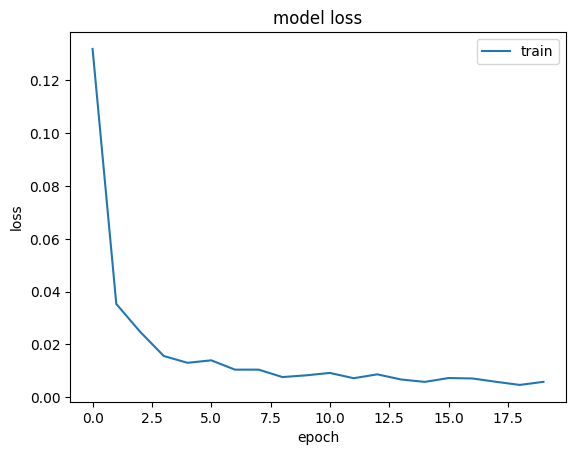

In [101]:
# summarize history for loss
plt.plot(history_2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

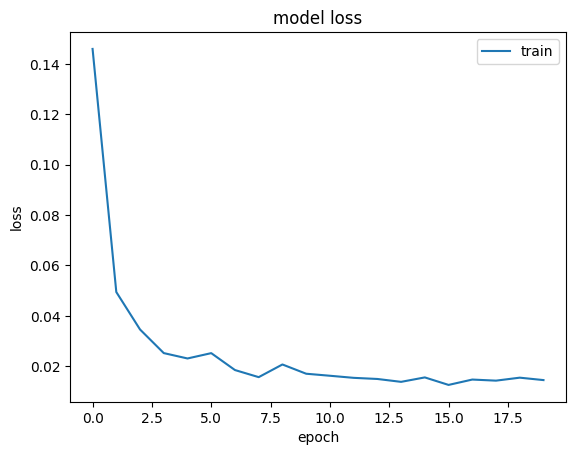

In [102]:
# summarize history for loss
plt.plot(history_3.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [106]:
model_1.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 sequential_15 (Sequential)     (None, 1)            2927        ['input_31[0][0]',               
                                                                  'input_32[0][0]']               
                                                                                                  
 subtract_15 (Subtract)         (None, 1)            0           ['sequential_15[0][0]',   

In [105]:
for i in range(len(X)):
    a=base_network_1.predict(X[i])- base_network_1.predict(Y[i])
    b=base_network_2.predict(X[i])- base_network_2.predict(Y[i])
    c=base_network_3.predict(X[i])- base_network_3.predict(Y[i])
    scores=[]
    if max(a,b,c)==a:
        score.append(0)
    if max(a,b,c)==a:
        score.append(1)
    if max(a,b,c)==a:
        score.append(2)





ValueError: in user code:

    File "c:\Users\maxim\anaconda\envs\xaiboost\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\maxim\anaconda\envs\xaiboost\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\maxim\anaconda\envs\xaiboost\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\maxim\anaconda\envs\xaiboost\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\maxim\anaconda\envs\xaiboost\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\maxim\anaconda\envs\xaiboost\lib\site-packages\keras\engine\input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_15" "                 f"(type Sequential).
    
    Input 0 of layer "dense_60" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer "sequential_15" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=float32)
      • training=False
      • mask=None
